In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community as nxcm
from sklearn.cluster import KMeans
from networkx import edge_betweenness_centrality as betweenness
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from datetime import datetime
import numpy as np
from scipy import stats




In [ ]:
G = nx.read_gml('karate.gml', label = 'id')
H = nx.read_gml('dolphins.gml', label = 'id')
fh=open("jazz.net", "rb")
I = nx.read_weighted_edgelist(fh)

# **Operating on Karate Club Graph**

In [ ]:
# Program for Girvan-Newman
def most_central_edge(G):
    centrality = betweenness(G, weight="weight") 
    return max(centrality, key=centrality.get) #For finding edge betweenness and returning max value 

comp_GN = nxcm.girvan_newman(G, most_valuable_edge=most_central_edge)
communities = list(nx.community.girvan_newman(G))

In [ ]:
#
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range


{'icoord': [[25.0, 25.0, 35.0, 35.0], [15.0, 15.0, 30.0, 30.0], [5.0, 5.0, 22.5, 22.5], [13.75, 13.75, 45.0, 45.0], [29.375, 29.375, 55.0, 55.0], [42.1875, 42.1875, 65.0, 65.0], [53.59375, 53.59375, 75.0, 75.0], [64.296875, 64.296875, 85.0, 85.0], [74.6484375, 74.6484375, 95.0, 95.0], [105.0, 105.0, 115.0, 115.0], [135.0, 135.0, 145.0, 145.0], [125.0, 125.0, 140.0, 140.0], [110.0, 110.0, 132.5, 132.5], [84.82421875, 84.82421875, 121.25, 121.25], [155.0, 155.0, 165.0, 165.0], [160.0, 160.0, 175.0, 175.0], [195.0, 195.0, 205.0, 205.0], [185.0, 185.0, 200.0, 200.0], [167.5, 167.5, 192.5, 192.5], [245.0, 245.0, 255.0, 255.0], [235.0, 235.0, 250.0, 250.0], [225.0, 225.0, 242.5, 242.5], [233.75, 233.75, 265.0, 265.0], [215.0, 215.0, 249.375, 249.375], [232.1875, 232.1875, 275.0, 275.0], [253.59375, 253.59375, 285.0, 285.0], [269.296875, 269.296875, 295.0, 295.0], [282.1484375, 282.1484375, 305.0, 305.0], [293.57421875, 293.57421875, 315.0, 315.0], [304.287109375, 304.287109375, 325.0, 325.0]

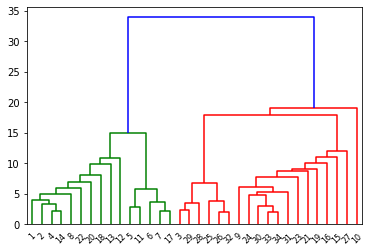

In [ ]:
M           = nx.DiGraph(node_id_to_children)
nodes       = M.nodes()
leaves      = set( n for n in nodes if M.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if M.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

plt.figure()
x=dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
print(x)
plt.show()

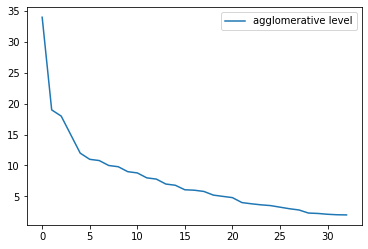

In [ ]:
#Inverse Skree Test for Karate Club Network
cluster_number = []
agg_level = []


for i in range(len(x['dcoord'])):
    cluster_number.append(i)
    agg_level.append(max(x['dcoord'][i]))
    
agg_level = sorted(agg_level)
cluster_number = sorted(cluster_number,reverse=True)

plt.plot(cluster_number,agg_level,label='agglomerative level')
plt.legend()

In [ ]:
# Program for Girvan-Newman for karate club
def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)
a = np.zeros(10)
for i in range(1,11):
    start_time = datetime.now()
    comp_GN = nxcm.girvan_newman(G, most_valuable_edge=most_central_edge)
    communities = list(nx.community.girvan_newman(G))
    end_time=datetime.now()
    ##print(end_time-start_time)
    runtime_algorithm_greivan_karate=(end_time-start_time).total_seconds() *1000
    a[i-1]=runtime_algorithm_greivan_karate

mode = stats.mode(a)
print("time taken in milliseconds")
print(format(float(mode[0]), 'f'))
first_division=next(comp_GN);
communities = list(nx.community.girvan_newman(G))
#print("-------------------------------------------------------")

time taken in milliseconds
135.370000
[{1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22}, {3, 9, 10, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}]


In [ ]:
#Modularity Maximization for Karate Club
a=np.zeros(5)
for i in range(1,6):
  start_time=datetime.now()
  comp_MM = list(nxcm.modularity_max.greedy_modularity_communities(G))
  end_time=datetime.now()
  runtime_algorithm_modularity_maximization=(end_time-start_time).total_seconds() *1000
  a[i-1]= runtime_algorithm_modularity_maximization
mode = stats.mode(a)
print("time taken")
print(format(float(mode[0]), 'f'))
for i in range (0,len(comp_MM)):
  print(sorted(comp_MM[i]))

time taken
5.950000
[9, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[2, 3, 4, 8, 10, 13, 14, 18, 22]
[1, 5, 6, 7, 11, 12, 17, 20]


In [ ]:
#Spectral Clustering for Karate network
K=len(first_division)
a=np.zeros(9)
for i in range(1,10):
  start_time = datetime.now()
  L = nx.laplacian_matrix(G)
  e, v = np.linalg.eig(L.todense()) 
  idx = np.argsort(e)
  e = e[idx]
  v = v[:,idx]
  v=v[:,1]
  kmeans = KMeans(n_clusters=K, random_state=0).fit(v.reshape(-1,1))
  ls = np.abs(kmeans.labels_)
  end_time=datetime.now()
  runtime_algorithm_spectral_clustering=(end_time-start_time).total_seconds() *1000
  a[i-1]=runtime_algorithm_spectral_clustering
mode = stats.mode(a)
print("time taken")
print(format(float(mode[0]), 'f'))
comp_SC=[]


for i in range(0,K):
  temp=[]
  for j in range(0,len(ls)):
    if(ls[j]==i):
      temp.append(j+1)
  comp_SC.append(temp)

print(comp_SC)

time taken
13.363000
[[2, 3, 4, 8, 9, 10, 14, 15, 16, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], [1, 5, 6, 7, 11, 12, 13, 17, 18, 22]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

**Karate Club Statistics**

In [ ]:
#no of communities of Karate Club
print("Karate Club")
print("Number of communities using Girvan Newman - ", len(first_division))
print("Number of communities using Modularity Maximization - ", len(comp_MM))
print("Number of communities using Spectral Clusternig - ", K)

Karate Club
Number of communities using Girvan Newman -  2
Number of communities using Modularity Maximization -  3
Number of communities using Spectral Clusternig -  2


In [ ]:
# modularity score for Karate Club 
print("Karate Club")
print("Modularity Score For Girvan Newman - ", nx.algorithms.community.quality.modularity(G,first_division))
print("Modularity Score For Modularity Maximization - ", nx.algorithms.community.quality.modularity(G,comp_MM))
print("Modularity Score For Spectral Clustering - ", nx.algorithms.community.quality.modularity(G,comp_SC))

Karate Club
Modularity Score For Girvan Newman -  0.3599605522682445
Modularity Score For Modularity Maximization -  0.3806706114398422
Modularity Score For Spectral Clustering -  0.233974358974359


# **Operating on Dolphins Social Network**

In [ ]:
# Program for Girvan-Newman
def most_central_edge(G):
    centrality = betweenness(G, weight="weight") 
    return max(centrality, key=centrality.get) #For finding edge betweenness and returning max value 

comp_GN = nxcm.girvan_newman(H, most_valuable_edge=most_central_edge)
communities = list(nx.community.girvan_newman(H))

In [ ]:

node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range


{'icoord': [[25.0, 25.0, 35.0, 35.0], [15.0, 15.0, 30.0, 30.0], [5.0, 5.0, 22.5, 22.5], [13.75, 13.75, 45.0, 45.0], [29.375, 29.375, 55.0, 55.0], [42.1875, 42.1875, 65.0, 65.0], [85.0, 85.0, 95.0, 95.0], [75.0, 75.0, 90.0, 90.0], [135.0, 135.0, 145.0, 145.0], [125.0, 125.0, 140.0, 140.0], [115.0, 115.0, 132.5, 132.5], [123.75, 123.75, 155.0, 155.0], [139.375, 139.375, 165.0, 165.0], [152.1875, 152.1875, 175.0, 175.0], [163.59375, 163.59375, 185.0, 185.0], [195.0, 195.0, 205.0, 205.0], [174.296875, 174.296875, 200.0, 200.0], [187.1484375, 187.1484375, 215.0, 215.0], [201.07421875, 201.07421875, 225.0, 225.0], [213.037109375, 213.037109375, 235.0, 235.0], [245.0, 245.0, 255.0, 255.0], [224.0185546875, 224.0185546875, 250.0, 250.0], [237.00927734375, 237.00927734375, 265.0, 265.0], [105.0, 105.0, 251.004638671875, 251.004638671875], [82.5, 82.5, 178.0023193359375, 178.0023193359375], [335.0, 335.0, 345.0, 345.0], [325.0, 325.0, 340.0, 340.0], [315.0, 315.0, 332.5, 332.5], [305.0, 305.0, 3

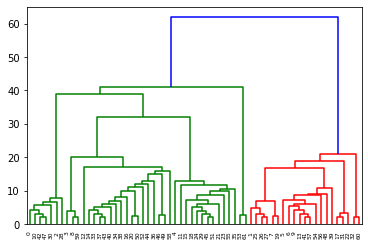

In [ ]:

M           = nx.DiGraph(node_id_to_children)
nodes       = M.nodes()
leaves      = set( n for n in nodes if M.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if M.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

plt.figure()
x=dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
print(x)
plt.show()

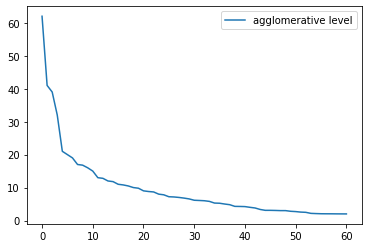

In [ ]:
#Inverse Skree Test for Dolphins Network
cluster_number = []
agg_level = []


for i in range(len(x['dcoord'])):
    cluster_number.append(i)
    agg_level.append(max(x['dcoord'][i]))
    
agg_level = sorted(agg_level)
cluster_number = sorted(cluster_number,reverse=True)

plt.plot(cluster_number,agg_level,label='agglomerative level')
plt.legend()

In [ ]:
#Girvan-Newman for Dolphins network
def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)
a = np.zeros(10)
for i in range(1,11):
    start_time = datetime.now()
    comp_GN = nxcm.girvan_newman(H, most_valuable_edge=most_central_edge)
    communities = list(nx.community.girvan_newman(H))
    end_time=datetime.now()
    ##print(end_time-start_time)
    runtime_algorithm_greivan_karate=(end_time-start_time).total_seconds() *1000
    a[i-1]=runtime_algorithm_greivan_karate

mode = stats.mode(a)
print("time taken")
print(format(float(mode[0]), 'f'))
first_division=communities[2]
print(sorted(first_division))

time taken
621.827000
[{0, 2, 10, 42, 47, 28, 30}, {1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 31, 32, 39, 41, 48, 54, 56, 57, 60}, {3, 4, 8, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 29, 33, 34, 35, 36, 37, 38, 40, 43, 44, 45, 46, 49, 50, 51, 52, 55, 58, 59}, {61, 53}]


In [ ]:
#Modularity Maximization for Dolphins network
a=np.zeros(5)
for i in range(1,6):
  start_time=datetime.now()
  comp_MM = list(nxcm.modularity_max.greedy_modularity_communities(H))
  end_time=datetime.now()
  runtime_algorithm_modularity_maximization=(end_time-start_time).total_seconds() *1000
  a[i-1]= runtime_algorithm_modularity_maximization
mode = stats.mode(a)
print("time taken in milliseconds")
print(format(float(mode[0]), 'f'))
for i in range (0,len(comp_MM)):
  print(sorted(comp_MM[i]))
print(comp_MM)

time taken in milliseconds
12.414000
[0, 2, 10, 12, 14, 16, 20, 33, 34, 37, 38, 40, 42, 43, 44, 46, 47, 49, 50, 52, 53, 58, 61]
[1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 28, 30, 31, 32, 41, 48, 54, 56, 57, 60]
[3, 4, 8, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55, 59]
[36, 39]
[frozenset({0, 2, 10, 12, 14, 16, 20, 33, 34, 37, 38, 40, 42, 43, 44, 46, 47, 49, 50, 52, 53, 58, 61}), frozenset({1, 5, 6, 7, 9, 13, 17, 19, 22, 25, 26, 27, 28, 30, 31, 32, 41, 48, 54, 56, 57, 60}), frozenset({35, 3, 4, 8, 11, 45, 15, 18, 51, 21, 55, 23, 24, 59, 29}), frozenset({36, 39})]


In [ ]:
#Spectral Clustering for DOlphins
K=4
a=np.zeros(9)
for i in range(1,10):
  start_time = datetime.now()
  L = nx.laplacian_matrix(H)
  e, v = np.linalg.eig(L.todense()) 
  idx = np.argsort(e)
  e = e[idx]
  v = v[:,idx]
  v=v[:,1]
  kmeans = KMeans(n_clusters=K, random_state=0).fit(v.reshape(-1,1))
  ls = np.abs(kmeans.labels_)
  print(ls)
  end_time=datetime.now()
  runtime_algorithm_spectral_clustering=(end_time-start_time).total_seconds() *1000
  a[i-1]=runtime_algorithm_spectral_clustering
mode = stats.mode(a)
print("time taken")
print(format(float(mode[0]), 'f'))
comp_SC=[]
for i in range(0,K):
  print(np.where(ls==i)[0]+1)


for i in range(0,K):
  temp=[]
  for j in range(0,len(ls)):
    if(ls[j]==i):
      temp.append(j+1)
  comp_SC.append(temp)

print(comp_SC)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3 2 1 1 2 2 1 2]
[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3 2 1 1 2 2 1 2]
[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3 2 1 1 2 2 1 2]
[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3 2 1 1 2 2 1 2]
[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3 2 1 1 2 2 1 2]
[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3 2 1 1 2 2 1 2]
[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3 2 1 1 2 2 1 2]
[2 3 2 2 2 1 1 3 2 1 2 2 2 1 2 2 2 1 2 3 2 2 1 2 2 1 3 3 0 2 0 1 1 2 2 2 0
 2 2 3 2 1 2 2 2 2 2 0 1 2 2 2 2 2 3

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


**Dolphin Social Network Statistics**

In [ ]:
#no of communities of Dolphins Club
print("Dolphins Social Network")
print("Number of communities using Girvan Newman - ", len(first_division))
print("Number of communities using Modularity Maximization - ", len(comp_MM))
print("Number of communities using Spectral Clusternig - ", K)

Dolphins Social Network
Number of communities using Girvan Newman -  4
Number of communities using Modularity Maximization -  4
Number of communities using Spectral Clusternig -  4


In [ ]:
#Modularity Score for Dolphins Network
print("Modularity score for Dolphins Social Network")
print("Modularity Score For Girvan Newman - ", nx.algorithms.community.quality.modularity(H,first_division))
print("Modularity Score For Modularity Maximization - ", nx.algorithms.community.quality.modularity(H,comp_MM))
print("Modularity Score For Spectral Clustering - ", nx.algorithms.community.quality.modularity(H,sorted(comp_SC_dolphins)))


Modularity score for Dolphins Social Network
Modularity Score For Girvan Newman -  0.45807127882599574
Modularity Score For Modularity Maximization -  0.4954906847039278
Modularity Score For Spectral Clustering -      0.4643215896245634


# **Operating on Jazz Network Graph**

In [ ]:
# Program for Girvan-Newman
def most_central_edge(G):
    centrality = betweenness(G, weight="weight") 
    return max(centrality, key=centrality.get) #For finding edge betweenness and returning max value 

comp_GN = nxcm.girvan_newman(I, most_valuable_edge=most_central_edge)
communities = list(nx.community.girvan_newman(I))

In [ ]:

node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range


{'icoord': [[175.0, 175.0, 185.0, 185.0], [165.0, 165.0, 180.0, 180.0], [155.0, 155.0, 172.5, 172.5], [145.0, 145.0, 163.75, 163.75], [135.0, 135.0, 154.375, 154.375], [125.0, 125.0, 144.6875, 144.6875], [115.0, 115.0, 134.84375, 134.84375], [105.0, 105.0, 124.921875, 124.921875], [95.0, 95.0, 114.9609375, 114.9609375], [85.0, 85.0, 104.98046875, 104.98046875], [75.0, 75.0, 94.990234375, 94.990234375], [65.0, 65.0, 84.9951171875, 84.9951171875], [55.0, 55.0, 74.99755859375, 74.99755859375], [45.0, 45.0, 64.998779296875, 64.998779296875], [35.0, 35.0, 54.9993896484375, 54.9993896484375], [44.99969482421875, 44.99969482421875, 195.0, 195.0], [119.99984741210938, 119.99984741210938, 205.0, 205.0], [162.4999237060547, 162.4999237060547, 215.0, 215.0], [188.74996185302734, 188.74996185302734, 225.0, 225.0], [206.87498092651367, 206.87498092651367, 235.0, 235.0], [220.93749046325684, 220.93749046325684, 245.0, 245.0], [232.96874523162842, 232.96874523162842, 255.0, 255.0], [243.9843726158142

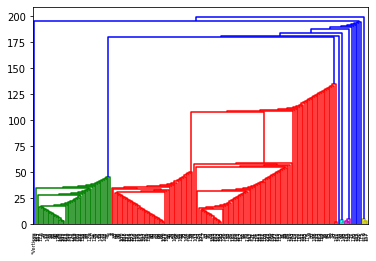

In [ ]:

M           = nx.DiGraph(node_id_to_children)
nodes       = M.nodes()
leaves      = set( n for n in nodes if M.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if M.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

plt.figure()
x=dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
print(x)
plt.show()

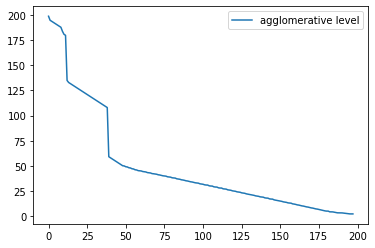

In [ ]:
#Inverse Skree Test for Jazz Network
cluster_number = []
agg_level = []


for i in range(len(x['dcoord'])):
    cluster_number.append(i)
    agg_level.append(max(x['dcoord'][i]))
    
agg_level = sorted(agg_level)
cluster_number = sorted(cluster_number,reverse=True)

plt.plot(cluster_number,agg_level,label='agglomerative level')
plt.legend()

In [ ]:
#Girvan-Newman for jazz musicians network
def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)
a = np.zeros(4)
for i in range(1,5):
    start_time = datetime.now()
    comp_GN = nxcm.girvan_newman(I, most_valuable_edge=most_central_edge)
    communities = list(nx.community.girvan_newman(I))
    end_time=datetime.now()
    ##print(end_time-start_time)
    runtime_algorithm_greivan_karate=(end_time-start_time).total_seconds() *1000
    a[i-1]=runtime_algorithm_greivan_karate
    print(a[i-1])

mode = stats.mode(a)
print("time taken")
print(format(float(mode[0]), 'f'))
first_division=communities[3]
print(sorted(first_division))

273921.326
269532.30000000005
268729.234
271624.28599999996
time taken
268729.234000
[{'*Vertices'}, {'68', '196', '72', '34', '159', '96', '77', '144', '74', '32', '84', '51', '49', '173', '142', '148', '62', '56', '53', '106', '95', '125', '73', '75', '7', '186', '167', '156', '60', '154', '118', '180', '17', '44', '181', '193', '13', '107', '164', '22', '197', '61', '45', '178', '47', '52', '177', '119', '93', '182', '89', '33', '25', '24', '42', '139', '179', '90', '195', '36', '54', '127', '185', '100', '78', '140', '27', '9', '66', '48', '102', '86', '162', '122', '120', '194', '58', '158', '163', '30', '187', '124', '4', '183', '128', '31', '3', '136', '71', '104', '50', '8', '20', '1', '192', '166', '145', '79', '184', '169', '109', '65', '57', '99', '170', '16', '40', '2', '59', '132', '11', '108', '135', '121', '43', '80', '18', '149', '138', '126', '29', '35', '55', '189', '190', '97', '63', '114', '82', '101', '26', '88', '168', '98', '137', '5', '143', '112', '147', '117',

In [ ]:
#Modularity Maximization for Jazz network
a=np.zeros(5)
for i in range(1,6):
  start_time=datetime.now()
  comp_MM = list(nxcm.modularity_max.greedy_modularity_communities(I))
  end_time=datetime.now()
  runtime_algorithm_modularity_maximization=(end_time-start_time).total_seconds() *1000
  a[i-1]= runtime_algorithm_modularity_maximization
mode = stats.mode(a)
print("time taken")
print(format(float(mode[0]), 'f'))
for i in range (0,len(comp_MM)):
  print(sorted(comp_MM[i]))

time taken
245.578000
['1', '100', '101', '103', '104', '105', '106', '107', '108', '109', '110', '116', '119', '120', '122', '123', '131', '132', '134', '135', '139', '15', '154', '159', '16', '162', '166', '168', '17', '170', '171', '179', '182', '187', '188', '22', '23', '24', '32', '33', '35', '38', '40', '42', '43', '44', '46', '48', '50', '58', '60', '62', '63', '64', '65', '66', '68', '74', '78', '8', '80', '81', '9', '91', '95', '98', '99']
['10', '11', '111', '112', '113', '114', '117', '118', '12', '121', '125', '127', '129', '130', '137', '14', '141', '142', '146', '150', '151', '158', '161', '164', '165', '174', '175', '177', '178', '183', '185', '186', '19', '190', '192', '193', '194', '195', '196', '197', '2', '20', '30', '31', '34', '36', '49', '52', '53', '54', '55', '56', '57', '61', '67', '69', '7', '70', '71', '72', '83', '84', '87', '89', '93', '94']
['*Vertices', '102', '115', '124', '126', '128', '13', '133', '136', '138', '140', '144', '145', '147', '148', '149',

In [ ]:
#Spectral Clustering for Jazz network
K=len(first_division)
a=np.zeros(9)
for i in range(1,10):
  start_time = datetime.now()
  L = nx.laplacian_matrix(I)
  e, v = np.linalg.eig(L.todense()) 
  idx = np.argsort(e)
  e = e[idx]
  v = v[:,idx]
  v=v[:,1]
  kmeans = KMeans(n_clusters=K, random_state=0).fit(v.reshape(-1,1))
  ls = np.abs(kmeans.labels_)
  end_time=datetime.now()
  runtime_algorithm_spectral_clustering=(end_time-start_time).total_seconds() *1000
  a[i-1]=runtime_algorithm_spectral_clustering
mode = stats.mode(a)
print("time taken")
print(format(float(mode[0]), 'f'))
comp_SC=[]
for i in range(0,K):
  print(np.where(ls==i)[0]+1)


for i in range(0,K):
  temp=[]
  for j in range(0,len(ls)):
    if(ls[j]==i):
      temp.append(j+1)
  comp_SC.append(temp)

print(comp_SC)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

time taken
88.267000
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 184 185 186 187 188 189
 190 192 193 194 195 196 197 198 199]
[80 81]
[ 32 183]
[79]
[ 31 145 181 182 191]
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 4

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


**Jazz Network Statistics**

In [ ]:
#no of communities of Jazz Club
print("Number of communities using Girvan Newman - ", len(first_division))
print("Number of communities using Modularity Maximization - ", len(comp_MM))
print("Number of communities using Spectral Clusternig - ", K)

Number of communities using Girvan Newman -  5
Number of communities using Modularity Maximization -  4
Number of communities using Spectral Clusternig -  5


In [ ]:
# modularity score for jazz netwrork
print("Jazz Musicians")
print("Modularity Score For Girvan Newman - ", nx.algorithms.community.quality.modularity(I,first_division))
print("Modularity Score For Modularity Maximization - ", nx.algorithms.community.quality.modularity(I,comp_MM))
print("Modularity Score For Spectral Clustering - ", nx.algorithms.community.quality.modularity(I,comp_SC))




Jazz Musicians
Modularity Score For Girvan Newman -  0.0036250428459464867
Modularity Score For Modularity Maximization -  0.4390580789678537
Modularity Score For Spectral Clustering -    0.403974358974359
